In [144]:
import numpy as np
#from utils import *
import csv
import keras.utils
#from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.python.keras import backend as K
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 8} )
sess = tf.compat.v1.Session(config=config) 
K.set_session(sess)
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import save_model,load_model,Model
from tensorflow.keras.optimizers import Adam, RMSprop, Adamax
from tensorflow.keras.layers import Conv2D, UpSampling2D, AveragePooling2D, MaxPooling2D, Dense,Input, Dropout
from tensorflow.keras.layers import LeakyReLU,Reshape,BatchNormalization, Flatten
from tensorflow.keras.models import save_model
from tempfile import TemporaryFile

import pickle
import scipy.io as sio
import matplotlib.pyplot as plt
from IPython import display
import time
from sklearn.mixture import GaussianMixture
import umap
from copy import deepcopy
from PIL import Image
from sklearn.cluster import KMeans
from tensorflow.keras import regularizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

from tensorflow.keras.layers import Input, Conv2D, Activation, BatchNormalization, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications.resnet50 import ResNet50
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import SGD
from array import array 
import json


In [145]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import pathlib
pathlib.Path().absolute()

PosixPath('/home/dbose_usc_edu/codes/domain_adaptation_experiments/amazon_multi_domain_BERT/scripts')

In [146]:
zdim=64 # This is the dimension of intermediate latent variable (previous value 50)
epochs = 15000 #previous value 8000 # change to 20000
epochstep = epochs/100
nofclasses=2
batchsize=200 
nofprojections = 200

In [147]:
imgX = Input(shape=(768,), name="input_img", dtype='float32')  # adapt this if using `channels_first` image data format
labelX=K.placeholder(shape=(None,nofclasses),dtype='float32') #labels of input images oneHot

In [148]:
def encoderNN(imgX = imgX, nofclasses=nofclasses):

    x = Dense(zdim, activation='relu', use_bias=True)(imgX)
    encoderX = Model(imgX,x)
    
    return encoderX

def  classifierNN(nofclasses):

    yin =  Input(shape=( zdim,) )
    probX = Dense(units=nofclasses, activation='softmax', use_bias=True)(yin)
    classifier=Model(inputs=[yin],outputs=[probX])
    return classifier


In [149]:
import sys 
import os 
sys.path.append(os.path.join('..', 'preprocess_scripts'))
sys.path.append(os.path.join('..', 'utils'))
from generate_features_domain_adaptation import *

In [150]:
source="electronics"
target="books"
base_folder="/data/Multi_Domain_Data/BERT_features_v2/"
source_csv_file="/data/Multi_Domain_Data/parsed_csv_data/electronics/electronics_review_splits_combined.csv"
target_csv_file="/data/Multi_Domain_Data/parsed_csv_data/books/books_review_splits_combined.csv"
layer_name="cls_token"
dataX_train,labelX_train,dataX_test,labelX_test,dataY_train,labelY_train,dataY_test,labelY_test=extract_source_target_feature_set(source,target,base_folder,source_csv_file,target_csv_file,layer_name=layer_name)

In [151]:
print(labelX_train.shape)

(1600, 2)


In [152]:
from util_scripts import *
encoderX = encoderNN(imgX = imgX, nofclasses=nofclasses)
classifier = classifierNN(nofclasses)
loss=[]
gamma1 = 1e0
 
discriminationLoss=K.mean(K.binary_crossentropy(labelX,classifier(encoderX(imgX))))
regLoss = (K.mean(K.square(encoderX.weights[0]))+K.mean(K.square(classifier.weights[0])))
params=encoderX.weights  + classifier.weights 

gamma2  = 3e1
myLoss = discriminationLoss  + gamma1 * regLoss  
opt = Adam(lr=1e-3, decay=1e-5, epsilon=1e-2 , amsgrad=True )   #change lr to 1e-3

updates = opt.get_updates(myLoss,params)
train = K.function(inputs=[imgX,labelX],outputs=[discriminationLoss],updates=updates)

for itr in range(epochs):
    indTrainDataX,trainLabelX=batchGenerator(labelX_train,batchsize,nofclasses=nofclasses)
    trainDataX=dataX_train[indTrainDataX,...]
    loss.append(train(inputs=[trainDataX, trainLabelX ]))

In [141]:
loss_val=[l[0] for l in loss]

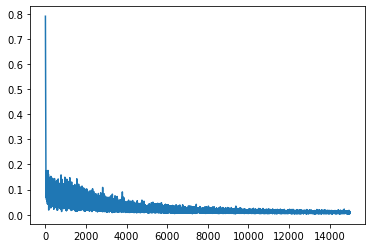

In [142]:
import matplotlib.pyplot as plt 
plt.plot(loss_val)
plt.show()

In [153]:
perd_label_Y = classifier.predict(encoderX.predict(dataY_test))
print(100*float(sum(1*(np.argmax(perd_label_Y,axis=1)==np.argmax(np.squeeze(labelY_test),axis=1))))/perd_label_Y.shape[0])

81.25


In [122]:
print(perd_label_X[0:10,:])

NameError: name 'perd_label_X' is not defined

In [55]:
print(labelX_test[0:10,:])

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [154]:
gmmX = encoderX.predict(dataX_train)
gmmY = np.argmax(labelX_train,axis=1)
yper = classifier.predict(encoderX.predict(dataX_train))
yperPro = np.max(yper, axis=1)
yper = np.argmax(yper, axis=1)
gmmX = gmmX[yperPro>.98,:]
gmmY = gmmY[yperPro>.98]

#increase max iter to 500
gmmModel =  GaussianMixture(n_components=nofclasses,covariance_type='full', max_iter=500,init_params='kmeans', tol=1e-04) 
gmmModel.fit(gmmX,gmmY)
gmmModelSingle =  GaussianMixture(n_components=1,covariance_type='full') 

for i in range(nofclasses):
    a= gmmX[gmmY==i,:]
    gmmModelSingle.fit(a)
    gmmModel.weights_[i] = gmmY[gmmY==i].shape[0]/gmmY.shape[0]
    gmmModel.covariances_[i] = gmmModelSingle.covariances_[0]
    gmmModel.means_[i] = gmmModelSingle.means_[0]

    gmmModel.precisions_cholesky_[i] = gmmModelSingle.precisions_cholesky_[0]
    gmmModel.precisions_[i] = gmmModelSingle.precisions_[0]

In [155]:
labelZ_train = np.concatenate([labelY_train,labelY_test],axis=0)
dataZ_train =  np.concatenate([dataY_train,dataY_test],axis=0)

In [156]:
encoderXsource = encoderNN(imgX=imgX, nofclasses=nofclasses)
encoderXsource.set_weights(encoderX.get_weights()) 
classifiersource = classifierNN(nofclasses)
classifiersource.set_weights(classifier.get_weights()) 

In [78]:
# imgY = Input(shape=(768,), name="input_img")  # adapt this if using `channels_first` image data format

# labelY=K.placeholder(shape=(None,nofclasses),dtype='float32') #labels of input images oneHot
# lamda2=1e-2

# theta=tf.keras.backend.placeholder(shape = (nofprojections, zdim), dtype='float32')

# discriminationLoss= K.mean(K.categorical_crossentropy(labelX,classifier(encoderX(imgX))))
# matchingLoss=sWasserstein(encoderX(imgX),encoderX(imgY),theta,nclass=nofclasses,Cp=None,Cq=None,)
# myLoss= discriminationLoss +lamda2*matchingLoss #+lamda*autorec
# params=encoderX.weights  + classifier.weights #+ decoderX.weights
# opt = Adam(lr=1e-2, decay=1e-4, epsilon=1e-2 , amsgrad=True ) 
# updates = opt.get_updates(myLoss,params)
# train = K.function(inputs=[imgY,imgX,labelX,theta],outputs=[lamda2*matchingLoss],updates=updates)

/home/dbose_usc_edu/miniconda3/envs/py36/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/home/dbose_usc_edu/miniconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("Adam/gradients_19/gradients/GatherV2_32_grad/Reshape_1:0", shape=(?,), dtype=int32), values=Tensor("Adam/gradients_19/gradients/GatherV2_32_grad/Reshape:0", shape=(?, 200), dtype=float32), dense_shape=Tensor("Adam/gradients_19/gradients/GatherV2_32_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/home/dbose_usc_edu/miniconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:449: Us

In [157]:
imgY = Input(shape=(768,), name="input_img")  # adapt this if using `channels_first` image data format

labelY=K.placeholder(shape=(None,nofclasses),dtype='float32') #labels of input images oneHot
#lamda2=1e-2

theta=tf.keras.backend.placeholder(shape = (nofprojections, zdim), dtype='float32')

thres = .95
epochs2 = 5 * 1000
epochstep = epochs2/1000
loss1 = []

imgY = Input(shape=(zdim,) )  # adapt this if using `channels_first` image data format
labelY=K.placeholder(shape=(None,nofclasses) ,dtype='float32') #labels of input images oneHot
#lamda2=2e2
#lamda2=1e2
lamda2=2e1

theta=tf.keras.backend.placeholder(shape = (nofprojections, zdim), dtype='float32')
labelW = K.placeholder(shape=(None,nofclasses) ,dtype='float32') #labels of input images oneHot
imgW = Input(shape=(768,), name="input_img", dtype='float32')  # adapt this if using `channels_first` image data format
discriminationLoss= K.mean(K.binary_crossentropy(labelY,classifier(imgY)))   \
                    + K.mean(K.categorical_crossentropy(labelW,classifier(encoderX(imgW))))

#gamma1 = 1e0
gamma1=1e1
#change 0.1 to 0.01
matchingLoss=sWasserstein(encoderX(imgX),imgY,theta,nclass=nofclasses,Cp=None,Cq=None,)
regLoss = (K.mean(K.square(encoderX.weights[0]))+K.mean(K.square(classifier.weights[0])))
myLoss= discriminationLoss +lamda2*matchingLoss + gamma1 * regLoss # + gamma2 * reconLoss

params=encoderX.weights  + classifier.weights #+ decoderX.weights
#opt=Adamax(learning_rate=1e-5)
opt=Adam(learning_rate=1e-3)
#opt = Adam(lr=1e-5, decay=1e-6, epsilon=1e-2 , amsgrad=True  ) # Adamax(lr=1e-5)#  very important 
#change lr to 1e-3
updates = opt.get_updates(myLoss,params)
train = K.function(inputs=[imgX,imgY,labelY,theta,imgW,labelW],outputs=[myLoss],updates=updates)

loss2 = []
epoch_pred_Y=[]


epochs2 = 30 * 1000 #change to 20000
epochstep = epochs2/1000

for itr in range(epochs2):
    indTrainDataY,trainLabelY=batchGenerator(labelZ_train,batchsize,nofclasses=nofclasses)
    trainDataY=dataZ_train[indTrainDataY,...]

    indTrainDataX,trainLabelX=batchGenerator(labelX_train,batchsize,nofclasses=nofclasses)
    trainDataX=dataX_train[indTrainDataX,...]    

    Yembed,Yembedlabel1  = gmmModel.sample(n_samples=10*batchsize)    
    Yembedlabel = keras.utils.np_utils.to_categorical(Yembedlabel1)   

    perdLabbatchY3 = classifier.predict(Yembed)
    problab = np.max(perdLabbatchY3,axis=1)

    NNN =  1*(problab>thres).sum()    
    trainDataYtemp = Yembed
    Yembed = np.zeros([NNN,zdim])
    trainLabelYY = np.zeros([NNN,nofclasses])
    count = 0
    for ijk in range(len(problab)):
        if problab[ijk] > thres:
            trainLabelYY[count,:] = 1*(perdLabbatchY3[ijk,:]>thres) 
            Yembed[count,:] = trainDataYtemp[ijk,:]
            count = count + 1    
    Yembedlabel = trainLabelYY
    theta_=generateTheta(nofprojections,zdim)
    loss2.append(train(inputs=[trainDataY,Yembed,Yembedlabel,theta_ ,trainDataX, trainLabelX ]))

    if(itr % epochstep ==0):
        perd_label_Y = classifier.predict(encoderX.predict(dataY_test))
        acc=(100*float(sum(1*(np.argmax(perd_label_Y,axis=1)==np.argmax(np.squeeze(labelY_test),axis=1))))/perd_label_Y.shape[0])
        epoch_pred_Y.append(acc)
        print('Epoch step: %d, Accuracy:%f' %(itr,acc))

/home/dbose_usc_edu/miniconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("Adam/gradients_14/gradients/GatherV2_8_grad/Reshape_1:0", shape=(?,), dtype=int32), values=Tensor("Adam/gradients_14/gradients/GatherV2_8_grad/Reshape:0", shape=(?, 200), dtype=float32), dense_shape=Tensor("Adam/gradients_14/gradients/GatherV2_8_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/home/dbose_usc_edu/miniconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("Adam/gradients_14/gradients/GatherV2_9_grad/Reshape_1:0", shape=(?,), dtype=int32), values=Tensor("Adam/gradients_14/gradients/GatherV2_9_grad/Reshape:0", shape=(?, 200), dtype=floa

Epoch step: 0, Accuracy:82.250000
Epoch step: 30, Accuracy:82.750000
Epoch step: 60, Accuracy:82.750000
Epoch step: 90, Accuracy:83.500000
Epoch step: 120, Accuracy:83.500000
Epoch step: 150, Accuracy:83.500000
Epoch step: 180, Accuracy:83.250000
Epoch step: 210, Accuracy:83.750000
Epoch step: 240, Accuracy:83.750000
Epoch step: 270, Accuracy:83.750000
Epoch step: 300, Accuracy:83.250000
Epoch step: 330, Accuracy:83.500000
Epoch step: 360, Accuracy:83.750000
Epoch step: 390, Accuracy:83.750000
Epoch step: 420, Accuracy:83.500000
Epoch step: 450, Accuracy:83.250000
Epoch step: 480, Accuracy:84.000000
Epoch step: 510, Accuracy:84.250000
Epoch step: 540, Accuracy:84.000000
Epoch step: 570, Accuracy:84.500000
Epoch step: 600, Accuracy:84.250000
Epoch step: 630, Accuracy:83.750000
Epoch step: 660, Accuracy:84.250000
Epoch step: 690, Accuracy:84.000000
Epoch step: 720, Accuracy:84.000000
Epoch step: 750, Accuracy:84.000000
Epoch step: 780, Accuracy:84.000000
Epoch step: 810, Accuracy:84.2500

In [131]:
perd_label_Y = classifier.predict(encoderX.predict(dataY_test))
print(100*float(sum(1*(np.argmax(perd_label_Y,axis=1)==np.argmax(np.squeeze(labelY_test),axis=1))))/perd_label_Y.shape[0])

85.5


In [127]:
loss2[0]

[3481.245]

In [128]:
loss_2_val=[l[0] for l in loss2]

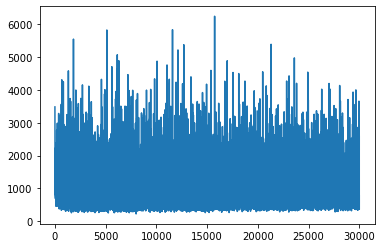

In [129]:
plt.plot(loss_2_val)
plt.show()

In [63]:
from tensorflow.python.keras import backend as K
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 8} )
sess = tf.compat.v1.Session(config=config) 
K.set_session(sess)

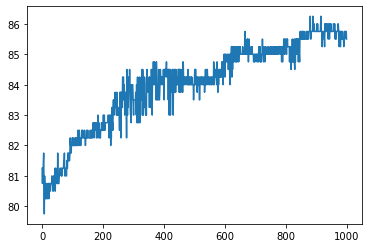

In [130]:
plt.plot(epoch_pred_Y)
plt.show()

In [152]:
loss_2_val[0:10]

[6485.911,
 5868.024,
 6040.713,
 6812.683,
 4932.7925,
 7181.6416,
 6951.7,
 6270.3057,
 4473.867,
 4943.1904]

In [90]:
loss_2_val[:-10]

[4354.697,
 2429.8945,
 1772.0784,
 1856.3987,
 2314.8865,
 1412.1768,
 1648.2241,
 1187.0638,
 1001.4984,
 1104.3235,
 1342.8333,
 861.4018,
 975.6599,
 1022.29376,
 2245.0063,
 1491.1888,
 2611.6887,
 1018.2208,
 891.8378,
 1158.7294,
 1530.6632,
 1132.0906,
 920.39825,
 1188.4619,
 986.39685,
 999.582,
 1234.6464,
 1009.57025,
 1952.9335,
 774.99274,
 1294.9297,
 1116.9788,
 993.54254,
 1004.74475,
 1037.149,
 930.87836,
 783.0793,
 1241.4269,
 1420.9526,
 734.2057,
 1796.2717,
 1075.6035,
 834.18024,
 857.9213,
 994.65424,
 803.1377,
 1792.8334,
 1363.7513,
 1341.2905,
 1904.1897,
 776.0994,
 1153.3616,
 943.92224,
 823.10144,
 856.5866,
 777.7968,
 913.62384,
 927.01575,
 1594.7933,
 670.8467,
 1569.8243,
 868.44806,
 1380.539,
 1730.7701,
 1287.3126,
 897.9361,
 1280.184,
 1284.9661,
 1218.9585,
 1578.9059,
 1227.8682,
 1461.1998,
 949.87354,
 1014.90924,
 689.4739,
 1222.9135,
 936.6379,
 1381.5154,
 1200.4939,
 1008.515,
 821.068,
 1268.8033,
 833.3666,
 756.3578,
 1077.687,
 2